In [1]:
import pandas as pd
MECE = {
    'Name': ['Samil Mithani', 'Mahima Patel','Varunan Gurushev', 'Gazal', 'Priya', 'Shiv Kapadia','Abhishek Singh','Rohit'],
    'ID': [500223143, 500223995, 500225040, 500225552,500225204 , 500203921, 500224576,500224882],
    'CONTRIBUTION': [
        'CNN and DNN using both images, ROC-AUC and confusion matrix in Samil_mahima_varunan file',
        'Data Preprocessing and Data augmentation in Samil_mahima_varunan file',
        'Implented Histogram Equalization in Samil_mahima_varunan file',
        'DNN and CNN building, Lime Interpretability in Gazal_Priya_Shiv file',
        'Data Preprocessing, Plotting AUC and Confusion Matrix in Gazal_Priya_Shiv file',
        'Fine Tunning in Gazal_Priya_Shiv file',
        '',
        ''
    ]
}

MECE_Table = pd.DataFrame(MECE)
MECE_Table

,Name,ID,CONTRIBUTION
0,Samil Mithani,500223143,"CNN and DNN using both images, ROC-AUC and con..."
1,Mahima Patel,500223995,Data Preprocessing and Data augmentation in Sa...
2,Varunan Gurushev,500225040,Implented Histogram Equalization in Samil_mahi...
3,Gazal,500225552,"DNN and CNN building, Lime Interpretability in..."
4,Priya,500225204,"Data Preprocessing, Plotting AUC and Confusion..."
5,Shiv Kapadia,500203921,Fine Tunning in Gazal_Priya_Shiv file
6,Abhishek Singh,500224576,
7,Rohit,500224882,


DNN and CNN using Both the images
Importing all the libraries

In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
def load_images_and_masks(base_path):
    categories = ['Normal', 'COVID-19', 'Non-COVID']
    image_data = []
    mask_data = []
    labels = []

    for category in categories:
        image_folder = os.path.join(base_path, category, 'images')
        mask_folder = os.path.join(base_path, category, 'lung masks')
        
        for image_name in os.listdir(image_folder):
            image_path = os.path.join(image_folder, image_name)
            mask_path = os.path.join(mask_folder, image_name)

            if os.path.exists(mask_path):
                # Load image and mask
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Convert to array
                image = img_to_array(image)
                mask = img_to_array(mask)

                image_data.append(image)
                mask_data.append(mask)
                labels.append(category)

    return np.array(image_data), np.array(mask_data), np.array(labels)

# Define the base path to your main folder
base_path = r'//Users/varunangurushev/Downloads/Val'

# Load images and masks
images, masks, labels = load_images_and_masks(base_path)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [4]:
# Merging lung x ray and mask images
data = np.concatenate((images,masks),axis=-1)

In [5]:
# Checking the shape of the merged data
data.shape

(5417, 256, 256, 2)

In [6]:
# Printing labels
labels

array([2, 2, 2, ..., 1, 1, 1])

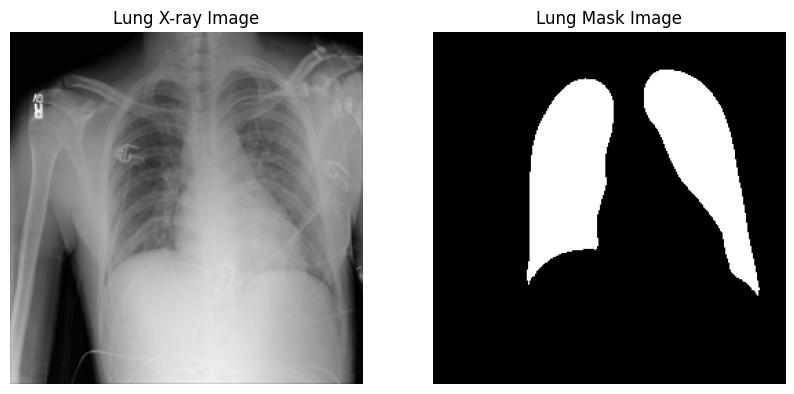

In [7]:
# Function to display an image and its mask
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Lung X-ray Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Lung Mask Image')
    plt.axis('off')
    plt.show()

# Choose a random index
random_index = random.randint(2005, len(images) - 1)

# Display the corresponding lung X-ray image and its mask
lung_image, mask_image = data[random_index][:, :, 0], data[random_index][:, :, 1]
display_image_and_mask(lung_image, mask_image)

Data Augmentation

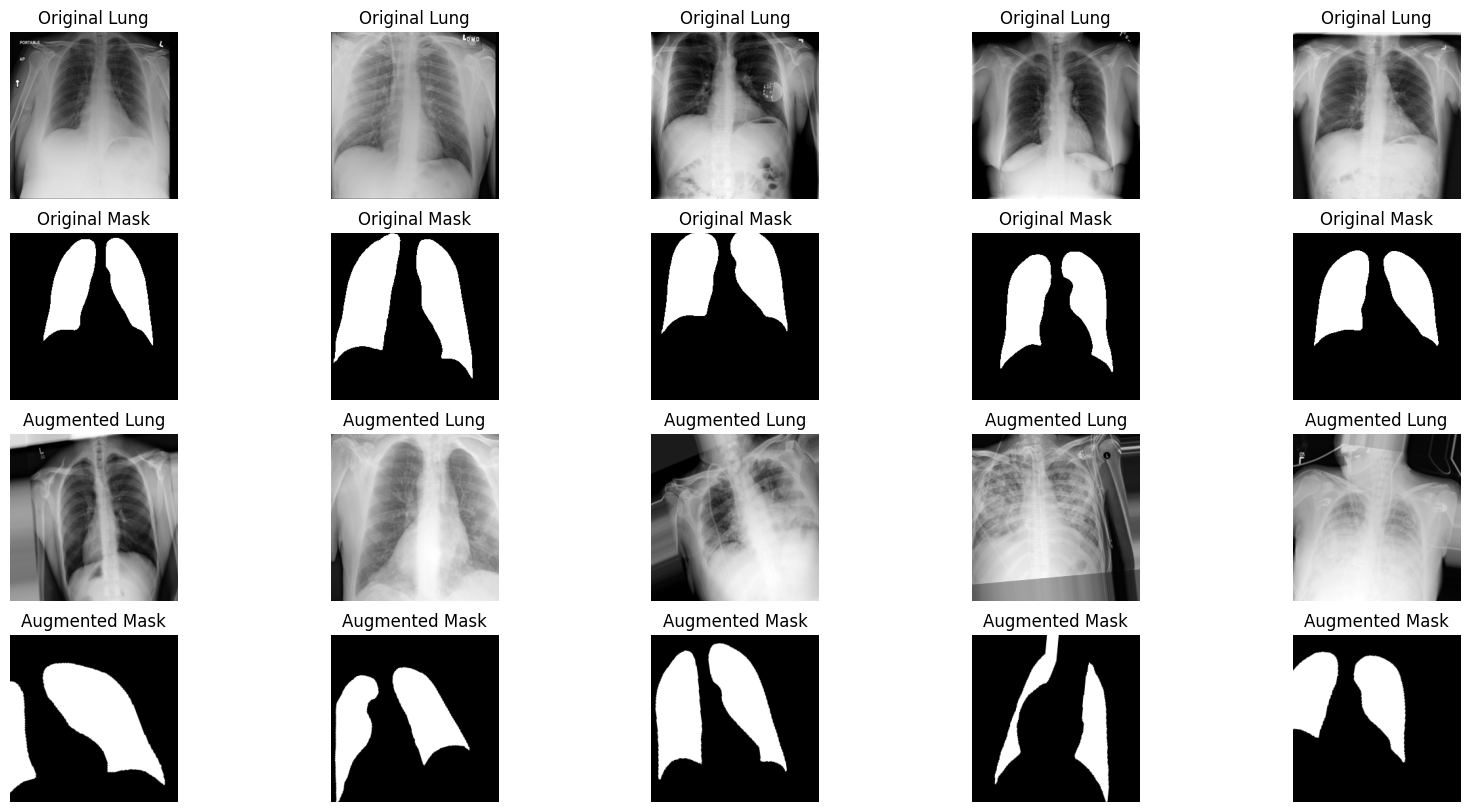

In [8]:
# data is a NumPy array of shape (num_samples, height, width, 2*channels)
# where the first half of the channels are lung images and the second half are mask images

# Split the main array into lung and mask images
num_samples, height, width, channels = data.shape
lung_images = data[:, :, :, :channels//2]
mask_images = data[:, :, :, channels//2:]

#Reshape labels to match the shape of image data
labels = labels.reshape(-1, 1, 1, 1)

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom generator to synchronize augmentation for lung and mask images
def custom_generator(lung_images, mask_images, labels, batch_size):
    gen_lung = datagen.flow(lung_images, batch_size=batch_size)
    gen_mask = datagen.flow(mask_images, batch_size=batch_size)
    gen_labels = datagen.flow(labels, batch_size=batch_size)
    while True:
        lung_batch = gen_lung.next()
        mask_batch = gen_mask.next()
        label_batch = gen_labels.next().flatten()
        yield lung_batch, mask_batch, label_batch

# Create an instance of the custom generator
batch_size = 32
augmented_data_generator = custom_generator(lung_images, mask_images, labels, batch_size)

# Function to visualize augmented images and masks
def visualize_augmented_images(original_lung_images, original_mask_images, augmented_lung_images, augmented_mask_images, num_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        # Original lung image
        plt.subplot(4, num_images, i + 1)
        plt.imshow(original_lung_images[i].squeeze(), cmap='gray')
        plt.title('Original Lung')
        plt.axis('off')
        
        # Original mask image
        plt.subplot(4, num_images, i + 1 + num_images)
        plt.imshow(original_mask_images[i].squeeze(), cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')
        
        # Augmented lung image
        plt.subplot(4, num_images, i + 1 + 2 * num_images)
        plt.imshow(augmented_lung_images[i].squeeze(), cmap='gray')
        plt.title('Augmented Lung')
        plt.axis('off')
        
        # Augmented mask image
        plt.subplot(4, num_images, i + 1 + 3 * num_images)
        plt.imshow(augmented_mask_images[i].squeeze(), cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')
    plt.show()

# Generate a batch of augmented images and masks
original_lung_images = lung_images[:5]  # Take the first 5 lung images for visualization
original_mask_images = mask_images[:5]  # Take the first 5 mask images for visualization

augmented_lung_images_batch, augmented_mask_images_batch, augmented_label_batch = next(augmented_data_generator)
augmented_lung_images = augmented_lung_images_batch[:5]  # Take the first 5 augmented lung images for visualization
augmented_mask_images = augmented_mask_images_batch[:5]  # Take the first 5 augmented mask images for visualization

# Visualize the original and augmented images and masks
visualize_augmented_images(original_lung_images, original_mask_images, augmented_lung_images, augmented_mask_images)

In [9]:
# Merging augmented labels with the labels 
labels = np.concatenate([labels.flatten(),augmented_label_batch])

In [10]:
# Merging augmented X-ray and mask images
merged_lung = np.concatenate([lung_images,augmented_lung_images_batch])
merged_mask = np.concatenate([mask_images,augmented_mask_images_batch])

In [11]:
# Merging all the augmented images into the data
data = np.concatenate((merged_lung,merged_mask),axis=-1)

In [12]:
	
# Checking shape of labels
labels.shape

(5449,)

In [13]:
# Checking the shape of the data after augmentation
data.shape

(5449, 256, 256, 2)

Performing Histogram Equalization

In [14]:
def histogram_equalization(image):

    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        gray = np.mean(image, axis=-1).astype(np.uint8)
    else:
        gray = image

     # Ensure the input image has the correct data type (uint8)
    if gray.dtype != np.uint8:
        gray = gray.astype(np.uint8)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    return equalized

# Perform histogram equalization
equalized_images = []
for i,image in enumerate(data):
    equalized_image = histogram_equalization(image)
    
    if len(image.shape) == 3:
        equalized_image = np.stack([equalized_image] * 2, axis=-1)

    equalized_images.append(equalized_image)

Plotting the original image and equalized image

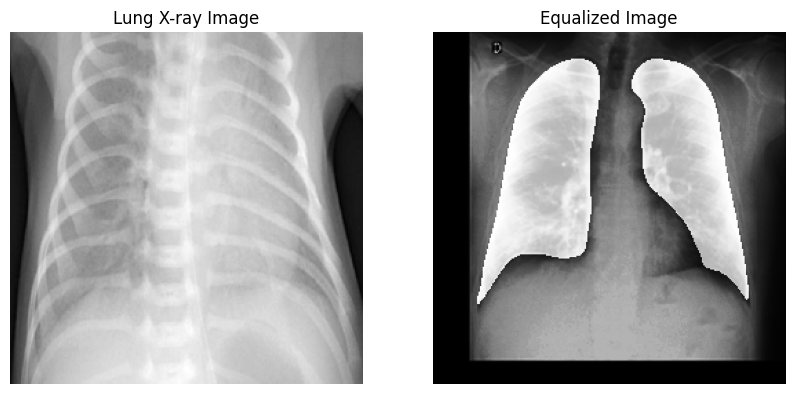

In [15]:
# Function to display an image and its mask
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Lung X-ray Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Equalized Image')
    plt.axis('off')
    plt.show()

# Choose a random index
random_index_or = random.randint(2001, len(images) - 1)
random_index_eq = random.randint(2001, len(images) - 1)

# Display the corresponding lung X-ray image and its mask
lung_image = data[random_index_or][:, :, 0]
eq_iamge = equalized_images[random_index_eq][:, :, 0]
display_image_and_mask(lung_image, eq_iamge)

In [16]:
# Shape of equalized imags
np.array(equalized_images).shape

(5449, 256, 256, 2)

CNN And DNN Using Equalized Images

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from lime import lime_tabular
import matplotlib.pyplot as plt


In [18]:
# Assigning Images to X and Labels to y
X = np.array(equalized_images)
y = labels

In [19]:
# splitting the training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# building the DNN model
dnn_model = Sequential([
    Flatten(input_shape=(256, 256, 2)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Training DNN model
dnn = dnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
  1/109 [..............................] - ETA: 14s - loss: 261.7268 - accuracy: 0.3750

2024-06-12 14:16:21.023041: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


109/109 [==============================] - 2s 18ms/step - loss: 2452.5623 - accuracy: 0.4502 - val_loss: 769.7609 - val_accuracy: 0.4679
Epoch 2/10
109/109 [==============================] - 2s 17ms/step - loss: 778.8514 - accuracy: 0.4961 - val_loss: 256.6409 - val_accuracy: 0.5849
Epoch 3/10
109/109 [==============================] - 2s 17ms/step - loss: 450.9064 - accuracy: 0.5337 - val_loss: 293.3918 - val_accuracy: 0.4495
Epoch 4/10
109/109 [==============================] - 2s 17ms/step - loss: 329.5875 - accuracy: 0.5475 - val_loss: 138.1650 - val_accuracy: 0.6170
Epoch 5/10
109/109 [==============================] - 2s 19ms/step - loss: 168.0647 - accuracy: 0.5824 - val_loss: 320.0003 - val_accuracy: 0.4862
Epoch 6/10
109/109 [==============================] - 2s 18ms/step - loss: 161.0857 - accuracy: 0.5672 - val_loss: 149.7558 - val_accuracy: 0.5447
Epoch 7/10
109/109 [==============================] - 2s 19ms/step - loss: 93.5060 - accuracy: 0.6114 - val_loss: 74.7679 - val_

In [22]:
# Calculating acuuracy,f1_score,precision,recall and confusion matrix
# evaluate the simple dnn model
y_pred_dnn = np.argmax(dnn_model.predict(X_test), axis=1)
y_pred_proba_dnn = dnn_model.predict(X_test)

# confusionmatrix
cm_dnn = confusion_matrix(y_test, y_pred_dnn)

# auc score
auc_score_dnn = roc_auc_score(y_test, y_pred_proba_dnn, multi_class='ovr')

# overall accuracy
accuracy_dnn = accuracy_score(y_test, y_pred_dnn)

# precision, recall and f1 score
precision_dnn = precision_score(y_test, y_pred_dnn, average='weighted')
recall_dnn = recall_score(y_test, y_pred_dnn, average='weighted')
f1_dnn = f1_score(y_test, y_pred_dnn, average='weighted')


print('Confusion Matrix:\n', cm_dnn)
print('AUC Score:', auc_score_dnn)
print('Accuracy:', accuracy_dnn)
print('Precision:', precision_dnn)
print('Recall:', recall_dnn)
print('F1 Score:', f1_dnn)

35/35 [==============================] - 0s 6ms/step
Confusion Matrix:
 [[270  70  10]
 [112 242  14]
 [122 122 128]]
AUC Score: 0.7455752845812039
Accuracy: 0.5871559633027523
Precision: 0.6476709308043711
Recall: 0.5871559633027523
F1 Score: 0.5735199279403931


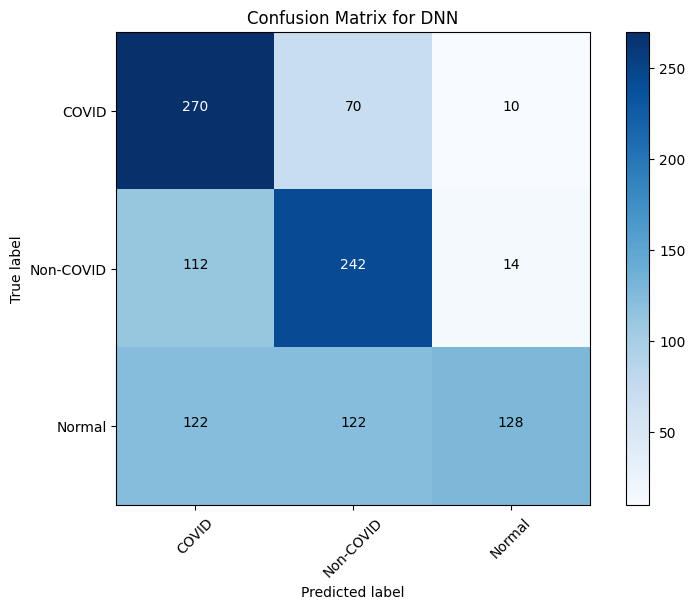

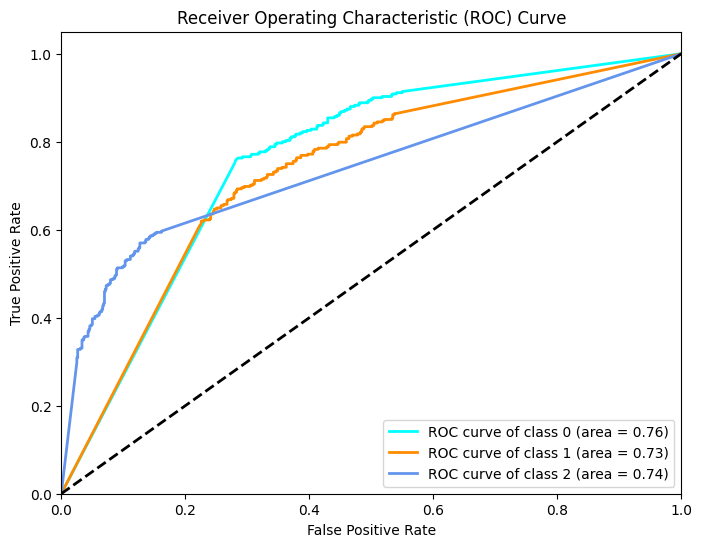

In [23]:
# Plotting Confusion Matrix and ROC-AUC Curve
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define class names for the confusion matrix
class_names = ['COVID', 'Non-COVID', 'Normal']

# Plot Confusion Matrix
plot_confusion_matrix(cm_dnn, classes=class_names, title='Confusion Matrix for DNN')

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba_dnn, n_classes=3)


In [24]:
from lime import lime_image

In [25]:
explainer = lime_image.LimeImageExplainer()

In [26]:
def predict_fn(images):
    images = images.astype('float32') / 255.0
    return dnn_model.predict(images)


In [27]:
# Select an image from the test set
image = X_test[0]


In [28]:
from lime import lime_image
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries

In [29]:
# Define the segmentation function
def segmentation_fn(image):
    return felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# Generate LIME explanation with the custom segmentation function
explanation = explainer.explain_instance(image, 
                                         predict_fn, 
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn=segmentation_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 8ms/step


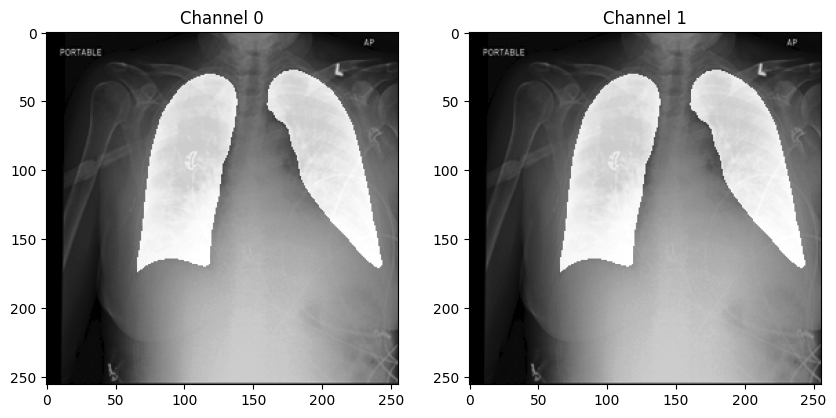

In [45]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(temp[:, :, 0], cmap='gray')
plt.title('Channel 0')

plt.subplot(1, 2, 2)
plt.imshow(temp[:, :, 1], cmap='gray')
plt.title('Channel 1')

plt.show()
|

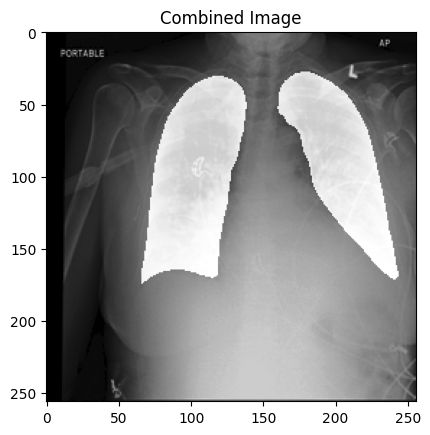

In [46]:
combined_image = np.mean(temp, axis=2)
plt.imshow(combined_image, cmap='gray')
plt.title('Combined Image')
plt.show()


In [ ]:
dnn_model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


Model Architecture Tuning


In [ ]:
from keras.layers import Dropout

dnn_model = Sequential([
    Flatten(input_shape=(256, 256, 2)),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
dnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.regularizers import l2
from keras.optimizers import Adam

dnn_model = Sequential([
    Flatten(input_shape=(256, 256, 2)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

dnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)


In [50]:
# Building CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,2)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Number of classes
])

In [51]:
# Compiling CNN Model
cnn_model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
	
# Training CNN model 
cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
109/109 [==============================] - 53s 481ms/step - loss: 38.6747 - accuracy: 0.5434 - val_loss: 0.9009 - val_accuracy: 0.6273
Epoch 2/10
109/109 [==============================] - 57s 525ms/step - loss: 0.7594 - accuracy: 0.7000 - val_loss: 0.6936 - val_accuracy: 0.7213
Epoch 3/10
109/109 [==============================] - 60s 552ms/step - loss: 0.6326 - accuracy: 0.7577 - val_loss: 0.8050 - val_accuracy: 0.6823
Epoch 4/10
109/109 [==============================] - 64s 583ms/step - loss: 0.5234 - accuracy: 0.7944 - val_loss: 0.7631 - val_accuracy: 0.6938
Epoch 5/10
109/109 [==============================] - 2342s 22s/step - loss: 0.4332 - accuracy: 0.8319 - val_loss: 0.8656 - val_accuracy: 0.7202
Epoch 6/10
109/109 [==============================] - 239s 2s/step - loss: 0.3386 - accuracy: 0.8695 - val_loss: 0.8224 - val_accuracy: 0.7397
Epoch 7/10
109/109 [==============================] - 59s 544ms/step - loss: 0.3093 - accuracy: 0.8879 - val_loss: 0.8604 - val_acc

In [53]:
# Calculating acuuracy,f1_score,precision,recall and confusion matrix
# evaluate the simple dnn model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_pred_proba_cnn = cnn_model.predict(X_test)

# confusionmatrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# auc score
auc_score_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr')

# overall accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# precision, recall and f1 score
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')


print('Confusion Matrix:\n', cm_cnn)
print('AUC Score:', auc_score_cnn)
print('Accuracy:', accuracy_cnn)
print('Precision:', precision_cnn)
print('Recall:', recall_cnn)
print('F1 Score:', f1_cnn)

35/35 [==============================] - 6s 159ms/step
Confusion Matrix:
 [[276  53  21]
 [ 40 280  48]
 [ 41  75 256]]
AUC Score: 0.8923501203712823
Accuracy: 0.744954128440367
Precision: 0.748769535195871
Recall: 0.744954128440367
F1 Score: 0.7450430191228994


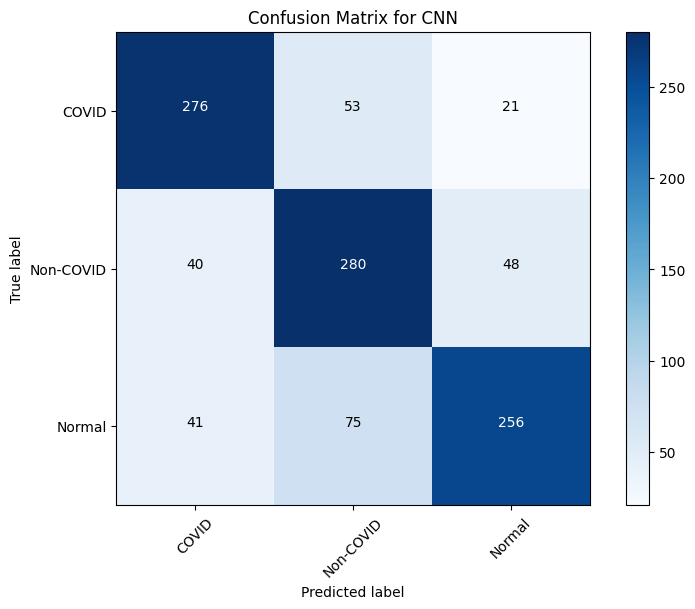

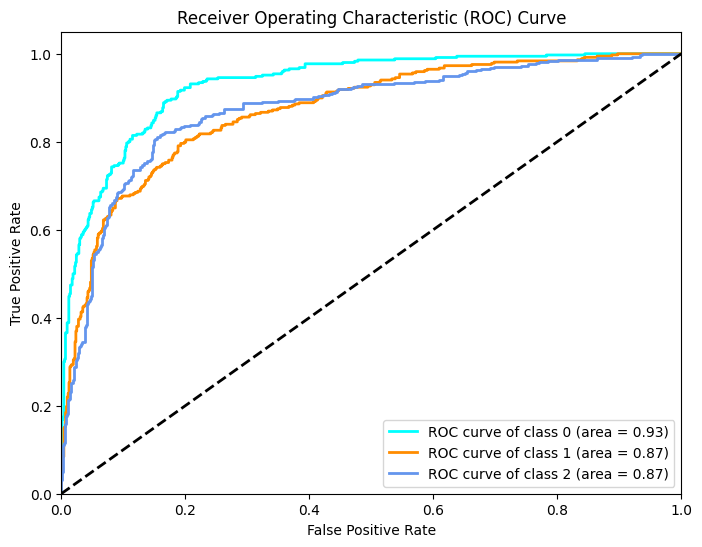

In [54]:
# Plotting Confusion Matrix and ROC-AUC Curve
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define class names for the confusion matrix
class_names = ['COVID', 'Non-COVID', 'Normal']

# Plot Confusion Matrix
plot_confusion_matrix(cm_cnn, classes=class_names, title='Confusion Matrix for CNN')

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba_cnn, n_classes=3)

In [55]:
explainer = lime_image.LimeImageExplainer()

In [56]:
def predict_fn(images):
    images = images.astype('float32') / 255.0
    return cnn_model.predict(images)


In [57]:
# Select an image from the test set
image = X_test[0]


In [58]:
# Define the segmentation function
def segmentation_fn(image):
    return felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# Generate LIME explanation with the custom segmentation function
explanation = explainer.explain_instance(image, 
                                         predict_fn, 
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn=segmentation_fn)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


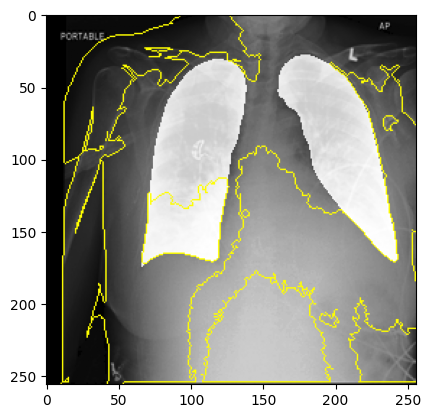

In [59]:
from skimage.segmentation import mark_boundaries

# Assuming you want to visualize only one channel of temp
# You can choose any channel you want, e.g., temp[:, :, 0] or temp[:, :, 1]
# Here, we are selecting the first channel (index 0)
selected_channel = temp[:, :, 0]

# Now, visualize the selected channel of temp with the mask
plt.imshow(mark_boundaries(selected_channel / 255.0, mask))
plt.show()


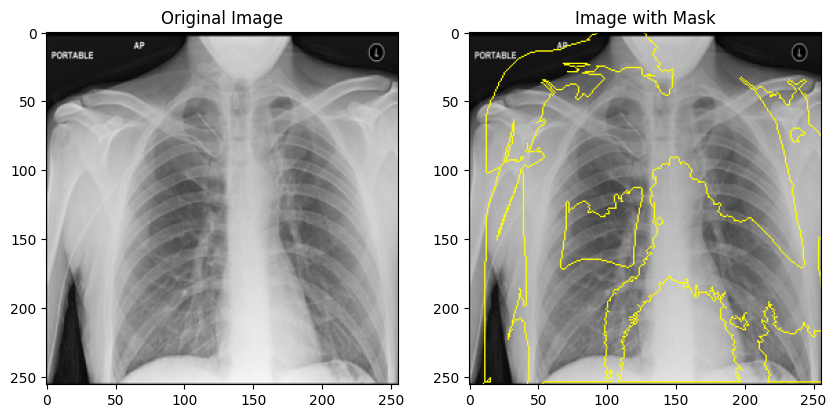

In [60]:
import random
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Choose a random index for the image
random_index = random.randint(0, len(images) - 1)

# Get the random image and its mask
random_image = images[random_index]  # Assuming 'images' is your list of images
random_mask = masks[random_index]    # Assuming 'masks' is your list of corresponding masks

# Assuming 'temp' is the image you want to visualize, and 'mask' is the corresponding mask
selected_channel = random_image[:, :, 0]  # Assuming you want to visualize only one channel
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(selected_channel, cmap='gray')
plt.title('Original Image')

# Convert label_img to integer type (uint8)
random_mask_uint8 = (random_mask * 255).astype(np.uint8)

# Visualize the selected channel of the image with the mask
plt.subplot(1, 2, 2)
plt.title('Image with Mask')
plt.imshow(mark_boundaries(selected_channel / 255.0, mask))
plt.show()



Optimizing Learning Rate and Batch Size

In [61]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[reduce_lr])


Epoch 1/10
109/109 [==============================] - 71s 654ms/step - loss: 11.6144 - accuracy: 0.5194 - val_loss: 0.9499 - val_accuracy: 0.5619 - lr: 0.0100
Epoch 2/10
109/109 [==============================] - 66s 607ms/step - loss: 1.0016 - accuracy: 0.5770 - val_loss: 0.9672 - val_accuracy: 0.6078 - lr: 0.0100
Epoch 3/10
109/109 [==============================] - 65s 593ms/step - loss: 0.9119 - accuracy: 0.5879 - val_loss: 1.0093 - val_accuracy: 0.5562 - lr: 0.0100
Epoch 4/10
109/109 [==============================] - 364s 3s/step - loss: 0.8729 - accuracy: 0.6100 - val_loss: 0.9382 - val_accuracy: 0.5894 - lr: 0.0100
Epoch 5/10
109/109 [==============================] - 54s 496ms/step - loss: 0.8362 - accuracy: 0.6258 - val_loss: 1.1253 - val_accuracy: 0.5917 - lr: 0.0100
Epoch 6/10
109/109 [==============================] - 57s 526ms/step - loss: 0.7887 - accuracy: 0.6504 - val_loss: 1.0535 - val_accuracy: 0.5803 - lr: 0.0100
Epoch 7/10
109/109 [==============================] -

In [62]:
# Calculating acuuracy,f1_score,precision,recall and confusion matrix
# evaluate the simple dnn model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_pred_proba_cnn = cnn_model.predict(X_test)

# confusionmatrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# auc score
auc_score_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr')

# overall accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# precision, recall and f1 score
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')


print('Confusion Matrix:\n', cm_cnn)
print('AUC Score:', auc_score_cnn)
print('Accuracy:', accuracy_cnn)
print('Precision:', precision_cnn)
print('Recall:', recall_cnn)
print('F1 Score:', f1_cnn)

35/35 [==============================] - 6s 184ms/step
Confusion Matrix:
 [[290  24  36]
 [109 152 107]
 [123  57 192]]
AUC Score: 0.7425902916113419
Accuracy: 0.581651376146789
Precision: 0.5942376918546745
Recall: 0.581651376146789
F1 Score: 0.5697150004613605


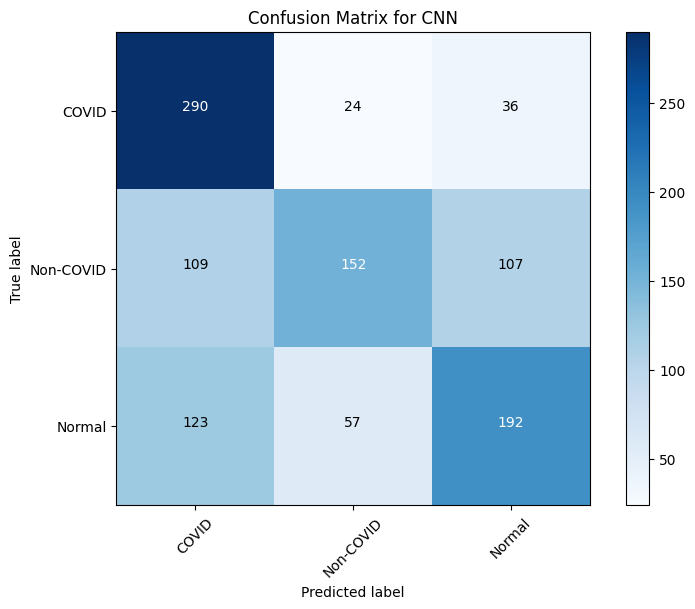

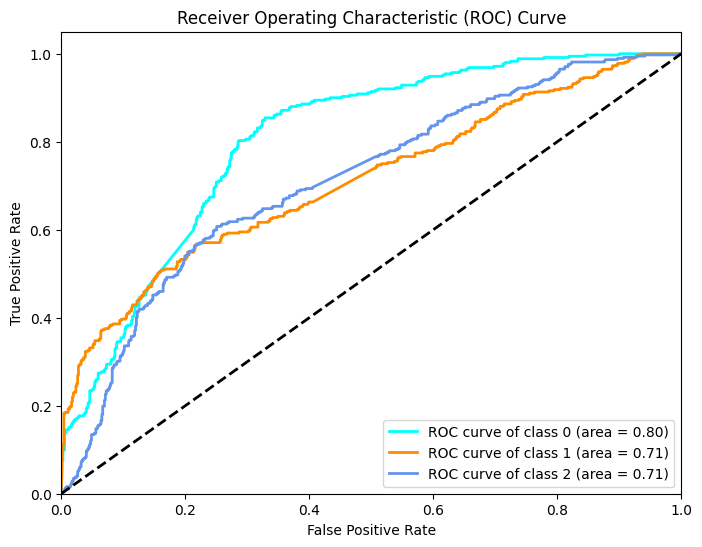

In [63]:
# Plotting Confusion Matrix and ROC-AUC Curve
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define class names for the confusion matrix
class_names = ['COVID', 'Non-COVID', 'Normal']

# Plot Confusion Matrix
plot_confusion_matrix(cm_cnn, classes=class_names, title='Confusion Matrix for CNN')

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba_cnn, n_classes=3)

Model Architecture Tuning

In [66]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 2)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[reduce_lr])


Epoch 1/10
109/109 [==============================] - 122s 1s/step - loss: 448.0825 - accuracy: 0.4236 - val_loss: 1.0219 - val_accuracy: 0.4576 - lr: 0.0100
Epoch 2/10
109/109 [==============================] - 115s 1s/step - loss: 0.9930 - accuracy: 0.5099 - val_loss: 0.9494 - val_accuracy: 0.5241 - lr: 0.0100
Epoch 3/10
109/109 [==============================] - 112s 1s/step - loss: 0.9748 - accuracy: 0.5237 - val_loss: 0.9807 - val_accuracy: 0.4977 - lr: 0.0100
Epoch 4/10
109/109 [==============================] - 851s 8s/step - loss: 0.9665 - accuracy: 0.5156 - val_loss: 0.9492 - val_accuracy: 0.5390 - lr: 0.0100
Epoch 5/10
109/109 [==============================] - 90s 830ms/step - loss: 0.9263 - accuracy: 0.5509 - val_loss: 0.9482 - val_accuracy: 0.5252 - lr: 0.0100
Epoch 6/10
109/109 [==============================] - 84s 770ms/step - loss: 0.9090 - accuracy: 0.5555 - val_loss: 0.9589 - val_accuracy: 0.5218 - lr: 0.0100
Epoch 7/10
109/109 [==============================] - 106s

In [67]:
# Calculating acuuracy,f1_score,precision,recall and confusion matrix
# evaluate the simple dnn model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_pred_proba_cnn = cnn_model.predict(X_test)

# confusionmatrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

# auc score
auc_score_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr')

# overall accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# precision, recall and f1 score
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')


print('Confusion Matrix:\n', cm_cnn)
print('AUC Score:', auc_score_cnn)
print('Accuracy:', accuracy_cnn)
print('Precision:', precision_cnn)
print('Recall:', recall_cnn)
print('F1 Score:', f1_cnn)

35/35 [==============================] - 8s 236ms/step
Confusion Matrix:
 [[143  96 111]
 [ 51 267  50]
 [ 63  68 241]]
AUC Score: 0.7616818396485393
Accuracy: 0.5972477064220183
Precision: 0.5924166650071728
Recall: 0.5972477064220183
F1 Score: 0.5894639811617971


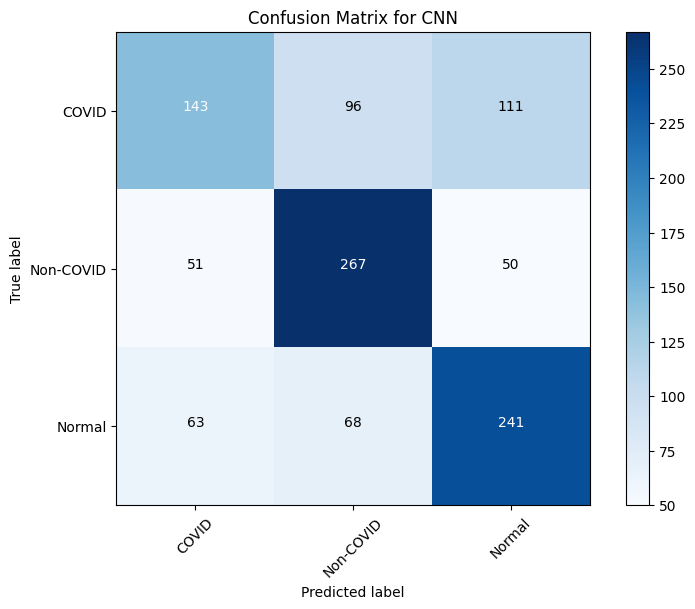

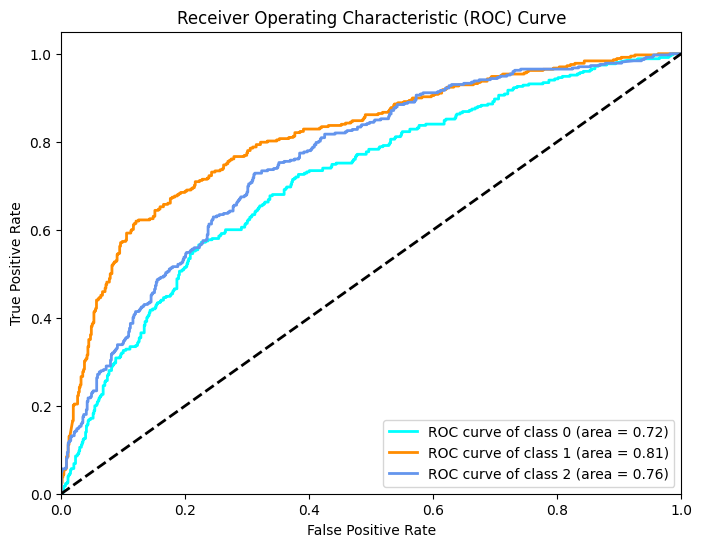

In [68]:
# Plotting Confusion Matrix and ROC-AUC Curve
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i, color in zip(range(n_classes), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define class names for the confusion matrix
class_names = ['COVID', 'Non-COVID', 'Normal']

# Plot Confusion Matrix
plot_confusion_matrix(cm_cnn, classes=class_names, title='Confusion Matrix for CNN')

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba_cnn, n_classes=3)